In [1]:
pip install torch

In [2]:
import torch

In [4]:
pip install transformers

Note: you may need to restart the kernel to use updated packages.


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5, Loss: 0.9610
Epoch 2/5, Loss: 0.8053
Epoch 3/5, Loss: 0.7898
Epoch 4/5, Loss: 0.6735
Epoch 5/5, Loss: 0.4640
Validation Accuracy: 82.61%


<Figure size 1000x700 with 0 Axes>

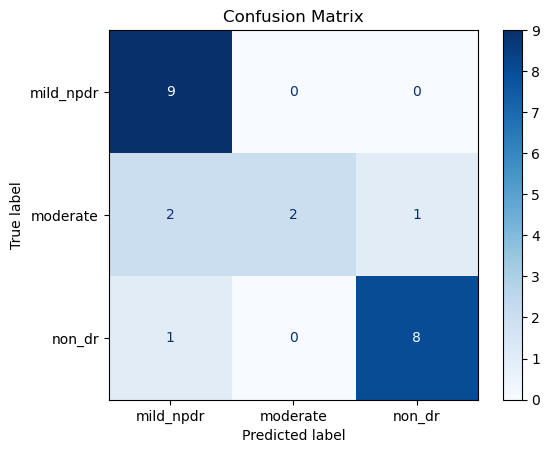

In [22]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from transformers import ViTForImageClassification, ViTConfig
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
train_dataset = ImageFolder("C:/Users/anita/Downloads/dataset1/train", transform=transform)
val_dataset = ImageFolder("C:/Users/anita/Downloads/dataset1/val", transform=transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
num_classes = len(train_dataset.classes)
config = ViTConfig.from_pretrained("google/vit-base-patch16-224-in21k")
config.num_labels = num_classes  
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k", config=config)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)
epochs = 5
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images).logits  
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {train_loss / len(train_loader):.4f}")
model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).logits
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
accuracy = 100 * correct / total
print(f"Validation Accuracy: {accuracy:.2f}%")
conf_matrix = confusion_matrix(all_labels, all_preds)
cm_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=train_dataset.classes)
plt.figure(figsize=(10, 7))
cm_display.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()